In [202]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from tensorflow.keras.optimizers import Adam, SGD
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                          Dropout, Rescaling, RandomFlip, RandomRotation, BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import zipfile
import os
import glob
import shutil

In [203]:
# fig = plt.figure(figsize=(16, 8))
# for i, path in enumerate(train_list[:10], 1):
#     subplot = fig.add_subplot(2, 5, i)
#     subplot.set_title('%s' %path.split('/')[1].split('.')[0])
#     img = cv2.imread(path)[...,::-1]
#     img = cv2.resize(img, (224,224))
#     plt.imshow(img)

In [204]:
img_height,img_width = 224, 224
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'E:/4--2/ML_PROJECT/Broken-Working-Website-Classification-Using-CNN/code/train_dataset/',
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True,
  label_mode='binary')


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'E:/4--2/ML_PROJECT/Broken-Working-Website-Classification-Using-CNN/code/train_dataset/',
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True,
  label_mode='binary')

Found 14126 files belonging to 2 classes.
Using 11301 files for training.
Found 14126 files belonging to 2 classes.
Using 2825 files for validation.


In [205]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [206]:
train_ds.class_names

['broken', 'non-broken']

In [207]:
rescale = Sequential([
  Rescaling(1./255)
])

In [208]:
# data_augmentation = Sequential([
#   RandomFlip("horizontal_and_vertical"),
#   RandomRotation(0.2),
# ])

In [209]:
# image = tf.expand_dims(img, 0)
# plt.figure(figsize=(10, 10))
# for i in range(9):
#   augmented_image = data_augmentation(image)
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(augmented_image[0])
#   plt.axis("off")

In [210]:
base_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   weights='imagenet', classes=2)
for layer in base_model.layers:
        layer.trainable=False

In [211]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [212]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l1(1e-4)))

In [213]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_14 (Flatten)        (None, 2048)              0         
                                                                 
 dense_25 (Dense)            (None, 256)               524544    
                                                                 
 batch_normalization_12 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_26 (Dense)            (None, 1)                 257       
                                                                 
Total params: 24,113,537
Trainable params: 525,313
Non-trainable params: 23,588,224
___________________________________

In [214]:
early_stop = EarlyStopping(monitor="val_loss",min_delta=0, patience=10,
                           verbose=0, mode="min", baseline=None, restore_best_weights=True)
check = ModelCheckpoint(filepath='convnet.keras', save_best_only=True, monitor='val_loss')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [215]:
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=SGD(learning_rate = 0.001, momentum = 0.1),
              metrics=['accuracy'])

In [216]:
num_epoch = 5
model_log = model.fit(train_ds,
                      epochs=num_epoch,
                      verbose=1,
                      validation_data=val_ds,
                      callbacks = [early_stop, check, learning_rate_reduction])


model.save_weights('weights.h5')

Epoch 1/5
354/354 [==============================] - 844s 2s/step - loss: 0.3222 - accuracy: 0.8706 - val_loss: 0.2569 - val_accuracy: 0.8931 - lr: 0.0010
Epoch 2/5
354/354 [==============================] - 1140s 3s/step - loss: 0.2479 - accuracy: 0.9034 - val_loss: 0.2266 - val_accuracy: 0.9080 - lr: 0.0010
Epoch 3/5
354/354 [==============================] - 1191s 3s/step - loss: 0.2255 - accuracy: 0.9147 - val_loss: 0.2127 - val_accuracy: 0.9122 - lr: 0.0010
Epoch 4/5
354/354 [==============================] - 842s 2s/step - loss: 0.2103 - accuracy: 0.9197 - val_loss: 0.2040 - val_accuracy: 0.9274 - lr: 0.0010
Epoch 5/5
354/354 [==============================] - 868s 2s/step - loss: 0.2016 - accuracy: 0.9234 - val_loss: 0.1979 - val_accuracy: 0.9299 - lr: 0.0010


In [217]:
from keras.preprocessing.image import ImageDataGenerator

# from tensorflow.keras.applications.resnet50 import preprocess_input
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
#
# test_data = ImageDataGenerator(preprocessing_function=preprocess_input,rescale=1.0/255).flow_from_directory(
#     directory = 'E:/4--2/ML_PROJECT/Broken-Working-Website-Classification-Using-CNN/code/test_dataset/',
#     target_size = (img_height,img_width),
#     batch_size = 32,
#     class_mode = None,
#     shuffle = False,
#     seed = 42
# )
test_path='E:/4--2/ML_PROJECT/Broken-Working-Website-Classification-Using-CNN/code/test_dataset/'
x_test=[]
for folder in os.listdir(test_path):

    sub_path=test_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_test.append(img_arr)
test_x=np.array(x_test)
test_x=test_x/255.0
test_datagen = ImageDataGenerator()
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle=True)
test_y=test_set.classes
print(test_y)
# pred = model.predict(test_x, steps = len(test_x), verbose = 1)
# print(pred)
model.evaluate(test_x,test_y,batch_size=32)



Found 1600 images belonging to 2 classes.
[0 0 0 ... 1 1 1]
50/50 [==============================] - 73s 1s/step - loss: 2.0258 - accuracy: 0.3750


[2.0257797241210938, 0.375]

In [200]:
# test_data.reset()

pred = model.predict(test_data, steps = len(test_data), verbose = 1)

 1/50 [..............................] - ETA: 2:17

KeyboardInterrupt: 

In [167]:
from PIL import Image


def load_test(given_path):
    x_test = []
    image_name = []

    # get the list of all images in the folder
    train_img_list = [f for f in os.listdir(given_path) if f.endswith('.jpg') or f.endswith('.png')]

    # convert each image into a matrix
    for img_name in train_img_list:
        img = Image.open(os.path.join(given_path, img_name))
        # print(img_name)
        img = img.resize((224,224))
        img_matrix = np.array(img)
        img_matrix = cv2.cvtColor(img_matrix, cv2.COLOR_BGR2RGB)
        # print("Image Matrix Shape:", img_matrix.shape)
        x_test.append(img_matrix)
        image_name.append(img_name)

    x_test = np.array(x_test)
    x_test = x_test / 255
    # x_test = (x_test - np.mean(x_test)) / np.std(x_test)
    # print("Training Image Matrix Shape:", x_train.shape)
    # image_info = []
    # with open(testing_csv) as csvfile:
    #     # print("opened")
    #     reader = csv.reader(csvfile)
    #     next(reader) # skip header row
    #     for row in reader:
    #         # print(row)
    #         image_name = row[6]
    #         print(image_name)
    #         image_path= os.path.join(path_testing_folder, image_name)
    #         label = int(row[2])
    #         print(label)
    #         image_info.append((image_path, label))
    return x_test

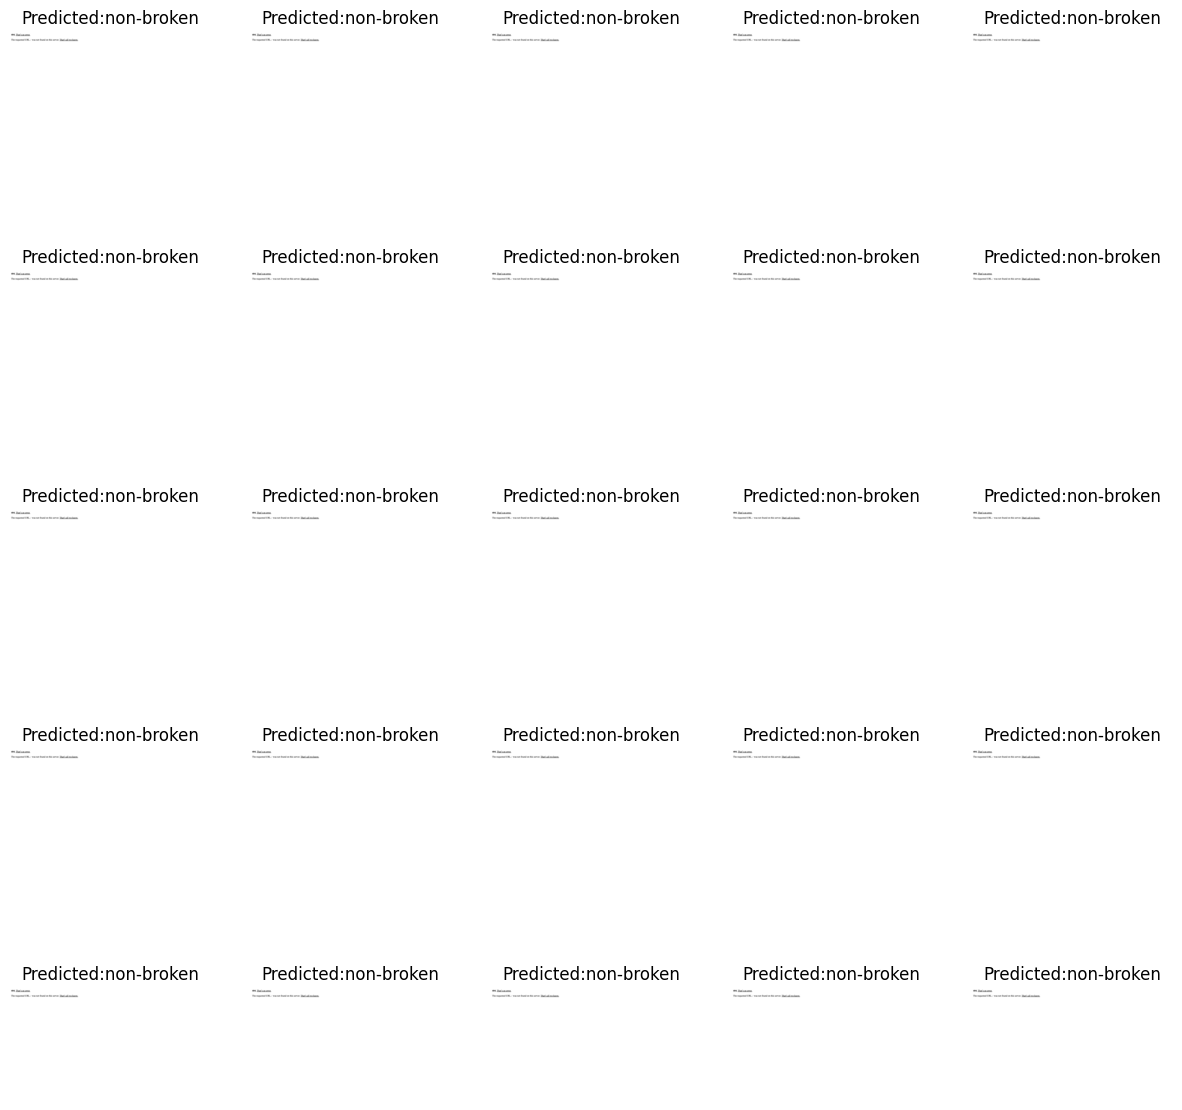

In [158]:
# f, ax = plt.subplots(5, 5, figsize = (15, 15))
#
# for i in range(0,25):
#     imgBGR = cv2.imread('E:/4--2/ML_PROJECT/Broken-Working-Website-Classification-Using-CNN/code/test_dataset/' + test_data.filenames[i])
#     imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
#
#     # a if condition else b
#     predicted_class = "broken " if pred[i] > 0.5 else "non-broken"
#
#     ax[i//5, i%5].imshow(imgRGB)
#     ax[i//5, i%5].axis('off')
#     ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))
#
# plt.show()
print(pred)

In [159]:
pred.clip(min=0.05, max=0.95)


array([[0.05],
       [0.05],
       [0.05],
       ...,
       [0.05],
       [0.05],
       [0.05]], dtype=float32)

In [160]:
loss_value , accuracy = model.evaluate(test_data)
print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

50/50 [==============================] - 4s 83ms/step - loss: 0.0037 - accuracy: 0.0000e+00
Test_loss_value = 0.003695945255458355
test_accuracy = 0.0
